Imports

In [87]:
import math
import statistics
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Reading CSV

In [88]:
gdp_data = pd.read_csv(r'..\gdp_csv.csv')
internet_speed_data = pd.read_csv(r'..\internet_speeds.csv', sep=";")
internet_access_data = pd.read_csv(r'..\internet_access.csv')
unemployment_data = pd.read_csv(r'..\unemployment.csv')
military_data = pd.read_csv(r'..\military_expenditure.csv')
happy_data = pd.read_csv(r'..\world_happiness_report_2022.csv', decimal=",", sep=";")
country_codes_data = pd.read_csv(r'..\country_codes.csv', sep=";")

gdp = pd.DataFrame(gdp_data, columns=['Country Code', 'Value', 'Year'])
internet_speed = pd.DataFrame(internet_speed_data, columns=['Country','Broadband Mbps', 'Mobile Mbps', 'As of'])
internet_access = pd.DataFrame(internet_access_data, columns=['LOCATION', 'Value', 'TIME'])
unemployment = pd.DataFrame(unemployment_data, columns=['LOCATION','Value', 'TIME', 'SUBJECT'])
military = pd.DataFrame(military_data, columns=['Code', '2018'])
happy = pd.DataFrame(happy_data, columns=['Country', 'Happiness score'])
country_codes = pd.DataFrame(country_codes_data, columns=['Country', 'Alpha-3 code'])

Renaming

In [89]:
gdp.rename(columns = {'Country Code':'CountryCode', 'Year':'YearGDP', 'Value':'GDP'}, inplace = True)
internet_speed.rename(columns = {'Country':'CountryName', 'Broadband Mbps':'BroadbandSpeed', 'Mobile Mbps':'MobileSpeed', 'As of':'YearInternetSpeed'}, inplace = True)
internet_access.rename(columns={'TIME':'YearInternetAccess', 'Value':'InternetAccess', 'LOCATION':'CountryCode'}, inplace= True)
unemployment.rename(columns= {'LOCATION':'CountryCode', 'Value':'Unemployment', 'TIME':'YearUnemployment', 'SUBJECT':'GenderUnemployment'}, inplace=True)
military.rename(columns= {'Code':'CountryCode', '2018':'MilitarySpending2018'}, inplace=True)
happy.rename(columns= {'Country':'CountryName', 'Happiness score':'HappinessScore2022'}, inplace=True)
country_codes.rename(columns= {'Alpha-3 code':'CountryCode', 'Country':'CountryName'}, inplace=True)

Removing unused Values

In [90]:
unemployment = unemployment[unemployment['GenderUnemployment'] == 'TOT']
unemployment.drop('GenderUnemployment', axis=1, inplace=True)
country_codes['CountryCode'] = country_codes['CountryCode'].replace({'"':''}, regex=True)
happy['CountryName'] = happy['CountryName'].replace({'\*':''}, regex=True)

Removing Duplicates

In [91]:
gdp.sort_values(by=['CountryCode','YearGDP'], ascending=False, inplace=True)
internet_speed.sort_values(by=['CountryName','YearInternetSpeed'], ascending=False, inplace=True)
internet_access.sort_values(by=['CountryCode', 'YearInternetAccess'], ascending=False, inplace=True)
unemployment.sort_values(by=['CountryCode', 'YearUnemployment'], ascending=False, inplace=True)

gdp.drop_duplicates(subset=['CountryCode'], keep='first', inplace=True)
internet_speed.drop_duplicates(subset=['CountryName'], keep='first', inplace=True)
internet_access.drop_duplicates(subset=['CountryCode'], keep='first', inplace=True)
unemployment.drop_duplicates(subset=['CountryCode'], keep='first', inplace=True)

Convert Units & Round

In [92]:
gdp['GDP'] = gdp['GDP'].div(1000000000).round(2)
military['MilitarySpending2018'] = military['MilitarySpending2018'].div(1000000).round(2)

Merging

In [93]:
internet_speed = pd.merge(internet_speed, country_codes, how='left', on='CountryName')
happy = pd.merge(happy, country_codes, how='left', on='CountryName')
happy.drop('CountryName', axis=1, inplace=True)
internet_speed['CountryCode'] = internet_speed['CountryCode'].str.strip()
happy['CountryCode'] = happy['CountryCode'].str.strip()
internet_access['CountryCode'] = internet_access['CountryCode'].str.strip()
unemployment['CountryCode'] = unemployment['CountryCode'].str.strip()
military['CountryCode'] = military['CountryCode'].str.strip()
dataset = pd.merge(internet_speed, gdp, how='left', on = 'CountryCode')
dataset = pd.merge(dataset, internet_access, how='left', on='CountryCode')
dataset = pd.merge(dataset, unemployment, how='left', on='CountryCode')
dataset = pd.merge(dataset, military, how='left', on='CountryCode')
dataset = pd.merge(dataset, happy, how='left', on='CountryCode')
dataset.head(2000)

,CountryName,BroadbandSpeed,MobileSpeed,YearInternetSpeed,CountryCode,GDP,YearGDP,InternetAccess,YearInternetAccess,Unemployment,YearUnemployment,MilitarySpending2018,HappinessScore2022
0,Zimbabwe,5.21,12.02,January 2022,ZWE,16.62,2016.0,NaN,NaN,NaN,NaN,420.36,2.995
1,Zambia,4.60,12.46,January 2022,ZMB,21.06,2016.0,NaN,NaN,NaN,NaN,378.03,3.760
2,Yemen,2.74,0.53,January 2022,YEM,27.32,2016.0,NaN,NaN,NaN,NaN,NaN,4.197
3,Western Sahara,10.51,NaN,January 2022,ESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Vietnam,67.50,39.01,January 2022,VNM,205.28,2016.0,NaN,NaN,NaN,NaN,5500.00,5.485
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Angola,11.97,25.43,January 2022,AGO,95.34,2016.0,NaN,NaN,NaN,NaN,1983.61,NaN
176,Andorra,92.42,NaN,January 2022,AND,2.86,2016.0,NaN,NaN,NaN,NaN,NaN,NaN
177,Algeria,9.72,11.31,January 2022,DZA,159.05,2016.0,NaN,NaN,NaN,NaN,9583.72,5.122
178,Albania,33.50,35.62,January 2022,ALB,11.86,2016.0,NaN,NaN,NaN,NaN,180.49,5.199


GDP - Broadband Speed

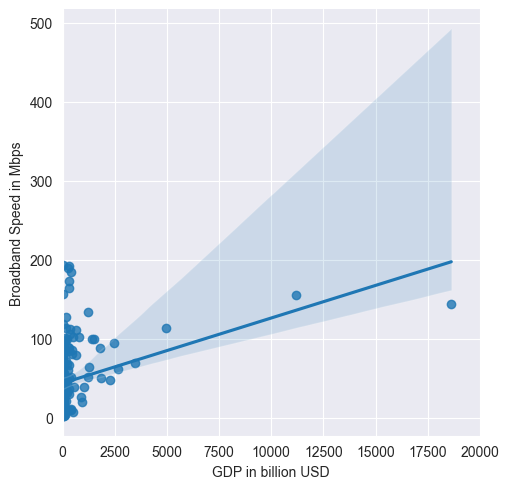

In [94]:
plotBroadBand = sns.lmplot(x="GDP", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('GDP in billion USD')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plt.xlim(0, 20000)
plotBroadBand.savefig(r'..\output\GDP - Broadband Speed.png')
plt.show()

GDP - Mobile Speed

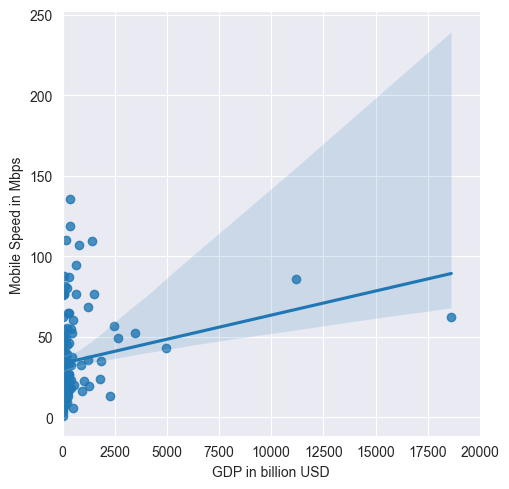

In [95]:
plotBroadBand = sns.lmplot(x="GDP", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('GDP in billion USD')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plt.xlim(0, 20000)
plotBroadBand.savefig(r'..\output\GDP - Mobile Speed.png')
plt.show()

Internet Access - Mobile Speed

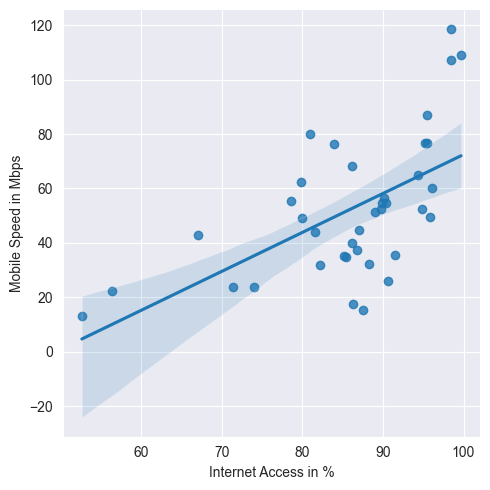

In [96]:
plotBroadBand = sns.lmplot(x="InternetAccess", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Internet Access in %')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Internet Access - Mobile Speed.png')
plt.show()

Internet Access - Broadband Speed

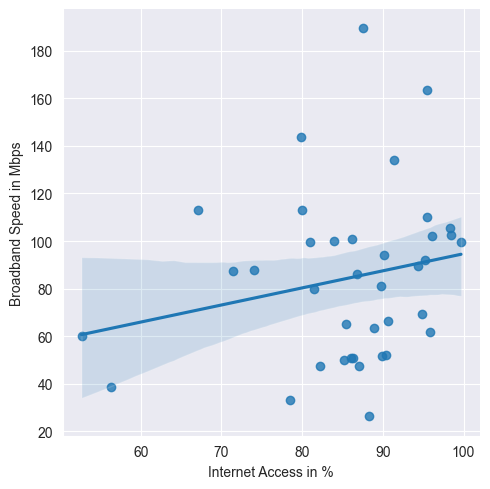

In [97]:
plotBroadBand = sns.lmplot(x="InternetAccess", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Internet Access in %')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Internet Access - Broadband Speed.png')
plt.show()

Unemployment - Mobile Speed

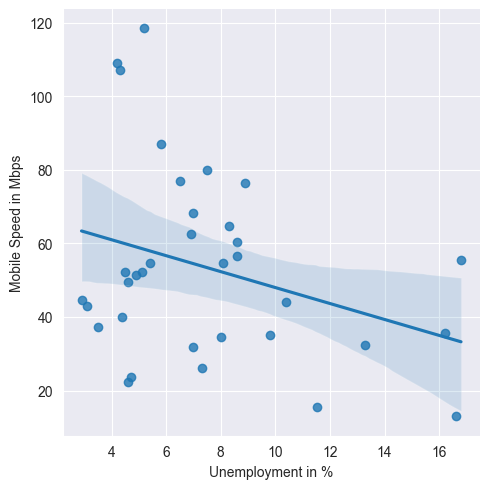

In [98]:
plotBroadBand = sns.lmplot(x="Unemployment", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Unemployment - Mobile Speed.png')
plt.show()

Unemployment - Broadband Speed

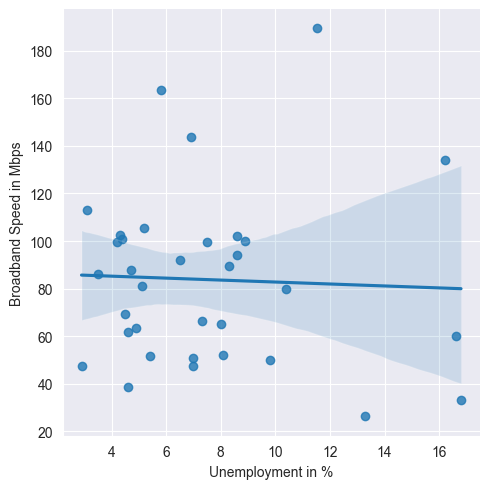

In [99]:
plotBroadBand = sns.lmplot(x="Unemployment", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Unemployment in %')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Unemployment - Broadband Speed.png')
plt.show()

Military Spending - Broadband Speed

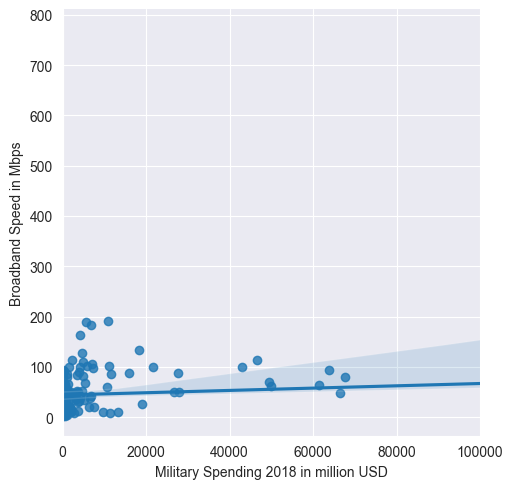

In [100]:
plotBroadBand = sns.lmplot(x="MilitarySpending2018", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Military Spending 2018 in million USD')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plt.xlim(0, 100000) #Ohne USA
plotBroadBand.savefig(r'..\output\Military Spending - Broadband Speed.png')
plt.show()

Military Spending - Mobile Speed

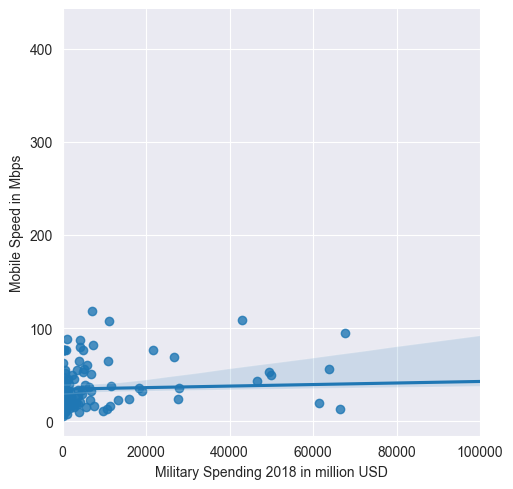

In [101]:
plotBroadBand = sns.lmplot(x="MilitarySpending2018", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Military Spending 2018 in million USD')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plt.xlim(0, 100000) #Ohne USA
plotBroadBand.savefig(r'..\output\Military Spending - Mobile Speed.png')
plt.show()

Happiness Score - Mobile Speed

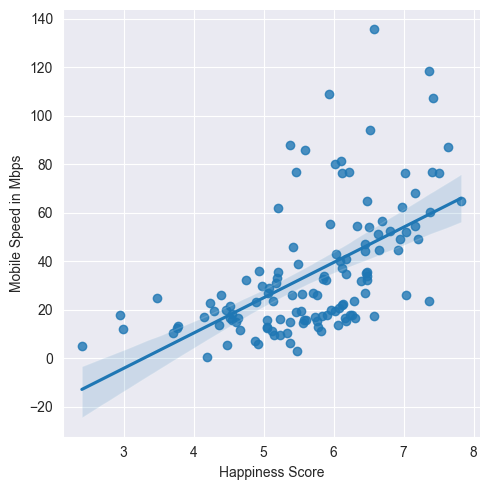

In [102]:
plotBroadBand = sns.lmplot(x="HappinessScore2022", y="MobileSpeed", data=dataset)
plotBroadBand.set_xlabels('Happiness Score')
plotBroadBand.set_ylabels('Mobile Speed in Mbps')
plotBroadBand.savefig(r'..\output\Happiness Score - Mobile Speed.png')
plt.show()

Happiness Score - Broadband Speed

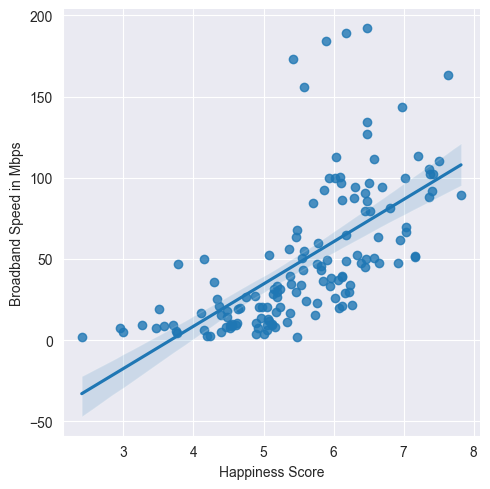

In [103]:
plotBroadBand = sns.lmplot(x="HappinessScore2022", y="BroadbandSpeed", data=dataset)
plotBroadBand.set_xlabels('Happiness Score')
plotBroadBand.set_ylabels('Broadband Speed in Mbps')
plotBroadBand.savefig(r'..\output\Happiness Score - Broadband Speed.png')
plt.show()

Boxplot GDP

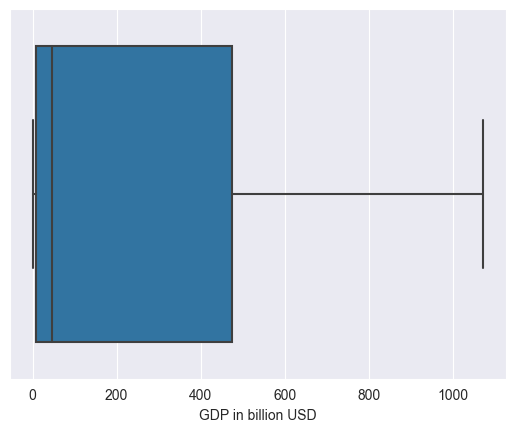

In [104]:
plotBroadBand = sns.boxplot(x=gdp['GDP'], showfliers = False)
#plotBroadBand = sns.swarmplot(x=gdp['GDP'], color="r")
plotBroadBand.set(
    xlabel='GDP in billion USD'
)
plotBroadBand.get_figure().savefig(r'..\output\GDP Boxplot.png')
plt.show()

Boxplot Mobile Speed

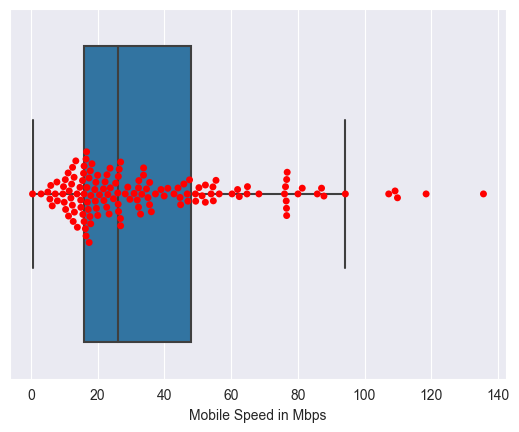

In [105]:
plotBroadBand = sns.boxplot(x=dataset['MobileSpeed'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['MobileSpeed'], color="r")
plotBroadBand.set(
    xlabel='Mobile Speed in Mbps'
)
plotBroadBand.get_figure().savefig(r'..\output\Mobile Speed Boxplot.png')
plt.show()

Boxplot Broadband Speed

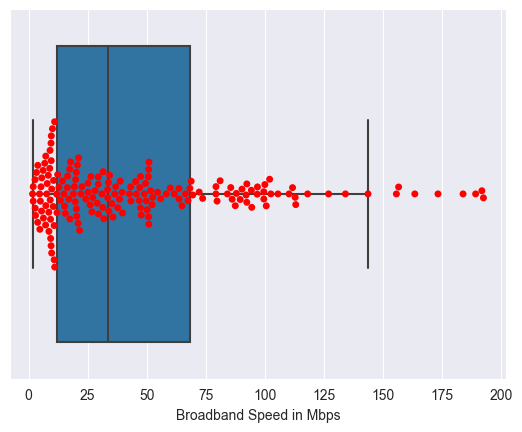

In [106]:
plotBroadBand = sns.boxplot(x=dataset['BroadbandSpeed'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['BroadbandSpeed'], color="r")
plotBroadBand.set(
    xlabel='Broadband Speed in Mbps'
)
plotBroadBand.get_figure().savefig(r'..\output\Broadband Speed Boxplot.png')
plt.show()

Happiness Score Boxplot

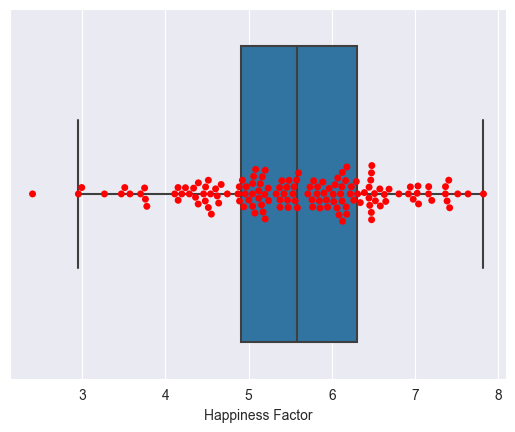

In [107]:
plotBroadBand = sns.boxplot(x=dataset['HappinessScore2022'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['HappinessScore2022'], color="r")
plotBroadBand.set(
    xlabel='Happiness Factor'
)
plotBroadBand.get_figure().savefig(r'..\output\Happiness Boxplot.png')
plt.show()

Unemployment Boxplot

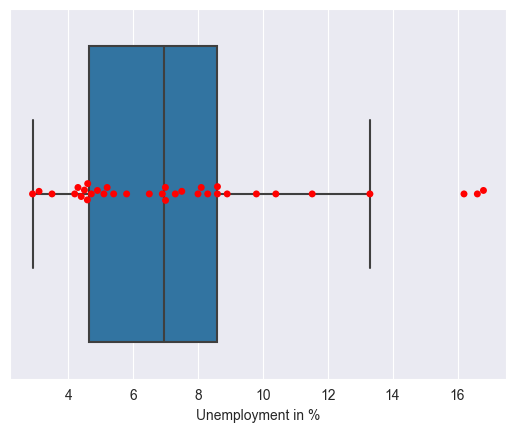

In [108]:
plotBroadBand = sns.boxplot(x=dataset['Unemployment'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['Unemployment'], color="r")
plotBroadBand.set(
    xlabel='Unemployment in %'
)
plotBroadBand.get_figure().savefig(r'..\output\Unemployment Boxplot.png')
plt.show()

Internet Access Boxplot

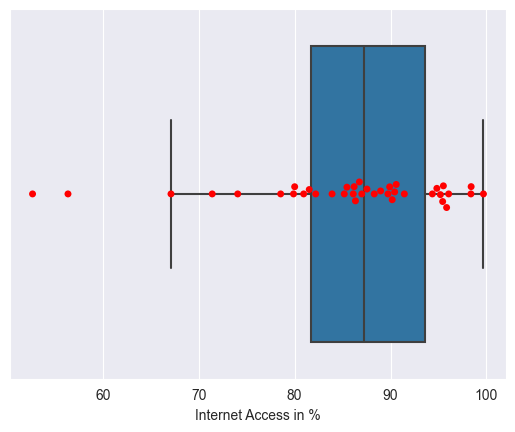

In [111]:
plotBroadBand = sns.boxplot(x=dataset['InternetAccess'], showfliers= False)
plotBroadBand = sns.swarmplot(x=dataset['InternetAccess'], color="r")
plotBroadBand.set(
    xlabel='Internet Access in %'
)
plotBroadBand.get_figure().savefig(r'..\output\Internet Access Boxplot.png')
plt.show()

Military Spending Boxplot

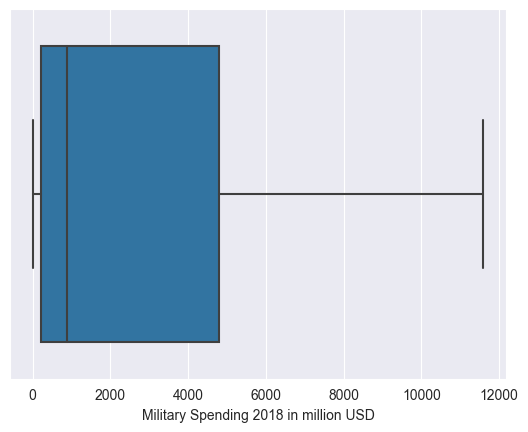

In [112]:
plotBroadBand = sns.boxplot(x=dataset['MilitarySpending2018'], showfliers= False)
#plotBroadBand = sns.swarmplot(x=dataset['MilitarySpending2018'], color="r")
plotBroadBand.set(
    xlabel='Military Spending 2018 in million USD'
)
plotBroadBand.get_figure().savefig(r'..\output\Military Spending Boxplot.png')
plt.show()